# Importing libraries

In [136]:
import os
import sys
import ast
import time
import random
import json
import requests
import numpy as np
from io import BytesIO
from functools import lru_cache
from IPython.display import display, Markdown
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from dotenv import load_dotenv

In [137]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

# Pretty printing helper

In [138]:
class CustomEncoder(json.JSONEncoder):
  def default(self, obj):
    try:
      return super().default(obj)
    except TypeError:
      return str(obj)


def pretty_print(obj, use_markdown=True):
  try:
    json_str = json.dumps(
        obj, indent=2, cls=CustomEncoder)
    if use_markdown:
      display(Markdown(f'```json\n{json_str}\n```'))
    else:
      print(json_str)

  except Exception as e:
    print(f"Error occurred while pretty printing: {e}")

# [download_image] helper

In [139]:
def download_image(image_file):
  # Check if the input is a URL
  if image_file.startswith(('http://', 'https://')):
    response = requests.get(image_file)
    response.raise_for_status()  # Raise an exception for bad status codes
    image_data = response.content
  else:  # Assuming it's a local file path
    with open(image_file, 'rb') as file:
      image_data = file.read()
  return Image.open(BytesIO(image_data))

# Loading environment variables

In [140]:
load_dotenv()
vision_endpoint = os.getenv('AI_SERVICE_ENDPOINT')
vision_key = os.getenv('AI_SERVICE_KEY')

True

# Create [ImageAnalysisClient]

In [141]:
client = ImageAnalysisClient(
    endpoint=vision_endpoint,
    credential=AzureKeyCredential(vision_key)
)

# Image analysis functions

In [142]:
def analyze_image(image_path_or_url, visual_features, **kwargs):
  if image_path_or_url.startswith("http://") or image_path_or_url.startswith("https://"):
    # If the image path looks like a URL, provide the URL to the analyze function
    result = client.analyze(image_url=image_path_or_url,
                            visual_features=visual_features, **kwargs)
  else:
    # If the image path is a local file path, read the image data from the file
    with open(image_path_or_url, "rb") as f:
      image_data = f.read()

    # Provide the image data to the analyze function
    result = client.analyze(image_data=image_data,
                            visual_features=visual_features, **kwargs)

  return result

In [143]:
@lru_cache(maxsize=None)
def analyze_image_cached(image_file):
  return analyze_image(image_path_or_url=image_file,
                       visual_features=[VisualFeatures.CAPTION,
                                        VisualFeatures.DENSE_CAPTIONS,
                                        VisualFeatures.TAGS,
                                        VisualFeatures.OBJECTS,
                                        VisualFeatures.PEOPLE,], gender_neutral_caption=True)

# Annotation functions

In [144]:
def get_random_color():
  colors = ['purple', 'brown', 'pink', 'cyan']
  return random.choice(colors)


def annotate_objects(result, image, confidence_threshold):
  draw = ImageDraw.Draw(image)

  for detected_object in result['objectsResult']['values']:
    object_name = detected_object['tags'][0]['name']
    confidence = detected_object['tags'][0]['confidence'] * 100

    if confidence < confidence_threshold:
      continue

    color = get_random_color()

    # Draw object bounding box
    bounding_box = (
        (detected_object['boundingBox']['x'],
         detected_object['boundingBox']['y']),
        (detected_object['boundingBox']['x'] + detected_object['boundingBox']['w'],
         detected_object['boundingBox']['y'] + detected_object['boundingBox']['h'])
    )
    draw.rectangle(bounding_box, outline=color, width=3)
    plt.annotate(object_name, (detected_object['boundingBox']['x'], detected_object['boundingBox']['y']),
                 backgroundcolor=color)


def annotate_people(result, image, confidence_threshold):
  draw = ImageDraw.Draw(image)

  for detected_people in result['peopleResult']['values']:
    if detected_people['confidence'] < confidence_threshold:
      continue

    color = get_random_color()

    r = detected_people['boundingBox']
    bounding_box = ((r['x'], r['y']), (r['x'] + r['w'], r['y'] + r['h']))
    draw.rectangle(bounding_box, outline=color, width=3)


def annotate(result, image_file, annotation_type, confidence_threshold=.05):
  image = download_image(image_file)
  fig = plt.figure(figsize=(image.width / 100, image.height / 100))
  plt.axis('off')

  if annotation_type == 'objects':
    annotate_objects(result, image, confidence_threshold)
    plt.title('Objects in the image')
  elif annotation_type == 'people':
    annotate_people(result, image, confidence_threshold)
    plt.title('People in the image')

  plt.imshow(image)
  plt.tight_layout(pad=0)
  plt.show()

In [145]:
# annotate(result, image_file, 'objects')
# annotate(result, image_file, 'people')

# Main logic

In [157]:
# image_file = 'https://img.freepik.com/premium-vector/crowd-people-big-group-different-people-vector_627350-3202.jpg'
# image_file = 'https://media.sciencephoto.com/f0/13/54/74/f0135474-800px-wm.jpg'
# image_file = 'https://static.timesofisrael.com/www/uploads/2019/05/000_1FR0ZF.jpg'
image_file = './images/street.jpg'

result = analyze_image_cached(image_file)

In [152]:
pretty_print(ast.literal_eval(str(result)), use_markdown=True)

```json
{
  "modelVersion": "2023-10-01",
  "captionResult": {
    "text": "a person feeding cats in a cage",
    "confidence": 0.7667706608772278
  },
  "denseCaptionsResult": {
    "values": [
      {
        "text": "a person feeding cats in a cage",
        "confidence": 0.7667641043663025,
        "boundingBox": {
          "x": 0,
          "y": 0,
          "w": 1024,
          "h": 663
        }
      },
      {
        "text": "a person in a blue jacket and white gloves picking up a can of dirt",
        "confidence": 0.6325570344924927,
        "boundingBox": {
          "x": 34,
          "y": 42,
          "w": 277,
          "h": 421
        }
      },
      {
        "text": "a black cat walking on a concrete surface",
        "confidence": 0.7031174898147583,
        "boundingBox": {
          "x": 800,
          "y": 357,
          "w": 183,
          "h": 151
        }
      },
      {
        "text": "a cat standing on a path",
        "confidence": 0.7187895774841309,
        "boundingBox": {
          "x": 602,
          "y": 253,
          "w": 146,
          "h": 112
        }
      },
      {
        "text": "a cat walking on the ground",
        "confidence": 0.6909535527229309,
        "boundingBox": {
          "x": 657,
          "y": 424,
          "w": 92,
          "h": 142
        }
      },
      {
        "text": "a cage with a bird inside",
        "confidence": 0.6722109913825989,
        "boundingBox": {
          "x": 134,
          "y": 389,
          "w": 216,
          "h": 118
        }
      },
      {
        "text": "a group of cats outside",
        "confidence": 0.7223630547523499,
        "boundingBox": {
          "x": 560,
          "y": 323,
          "w": 159,
          "h": 144
        }
      },
      {
        "text": "a cat walking on the ground",
        "confidence": 0.6526861190795898,
        "boundingBox": {
          "x": 373,
          "y": 320,
          "w": 207,
          "h": 166
        }
      },
      {
        "text": "a person wearing a hat",
        "confidence": 0.8042725920677185,
        "boundingBox": {
          "x": 240,
          "y": 48,
          "w": 77,
          "h": 60
        }
      },
      {
        "text": "a cat with its head in a cage",
        "confidence": 0.6049143075942993,
        "boundingBox": {
          "x": 328,
          "y": 349,
          "w": 144,
          "h": 129
        }
      }
    ]
  },
  "metadata": {
    "width": 1024,
    "height": 663
  },
  "tagsResult": {
    "values": [
      {
        "name": "outdoor",
        "confidence": 0.9835013747215271
      },
      {
        "name": "ground",
        "confidence": 0.9812160730361938
      },
      {
        "name": "person",
        "confidence": 0.9186859130859375
      },
      {
        "name": "plant",
        "confidence": 0.8604295253753662
      },
      {
        "name": "dog",
        "confidence": 0.7279434204101562
      },
      {
        "name": "standing",
        "confidence": 0.5755451917648315
      }
    ]
  },
  "objectsResult": {
    "values": [
      {
        "boundingBox": {
          "x": 655,
          "y": 437,
          "w": 100,
          "h": 137
        },
        "tags": [
          {
            "name": "dog",
            "confidence": 0.642
          }
        ]
      },
      {
        "boundingBox": {
          "x": 44,
          "y": 53,
          "w": 250,
          "h": 394
        },
        "tags": [
          {
            "name": "person",
            "confidence": 0.812
          }
        ]
      },
      {
        "boundingBox": {
          "x": 608,
          "y": 255,
          "w": 141,
          "h": 121
        },
        "tags": [
          {
            "name": "cat",
            "confidence": 0.756
          }
        ]
      },
      {
        "boundingBox": {
          "x": 322,
          "y": 355,
          "w": 157,
          "h": 126
        },
        "tags": [
          {
            "name": "mammal",
            "confidence": 0.508
          }
        ]
      },
      {
        "boundingBox": {
          "x": 401,
          "y": 350,
          "w": 179,
          "h": 140
        },
        "tags": [
          {
            "name": "cat",
            "confidence": 0.56
          }
        ]
      },
      {
        "boundingBox": {
          "x": 562,
          "y": 364,
          "w": 159,
          "h": 121
        },
        "tags": [
          {
            "name": "cat",
            "confidence": 0.533
          }
        ]
      },
      {
        "boundingBox": {
          "x": 807,
          "y": 361,
          "w": 177,
          "h": 144
        },
        "tags": [
          {
            "name": "dog",
            "confidence": 0.658
          }
        ]
      }
    ]
  },
  "peopleResult": {
    "values": [
      {
        "boundingBox": {
          "x": 40,
          "y": 52,
          "w": 276,
          "h": 412
        },
        "confidence": 0.9480531811714172
      },
      {
        "boundingBox": {
          "x": 53,
          "y": 183,
          "w": 251,
          "h": 145
        },
        "confidence": 0.0010767040075734258
      }
    ]
  }
}
```

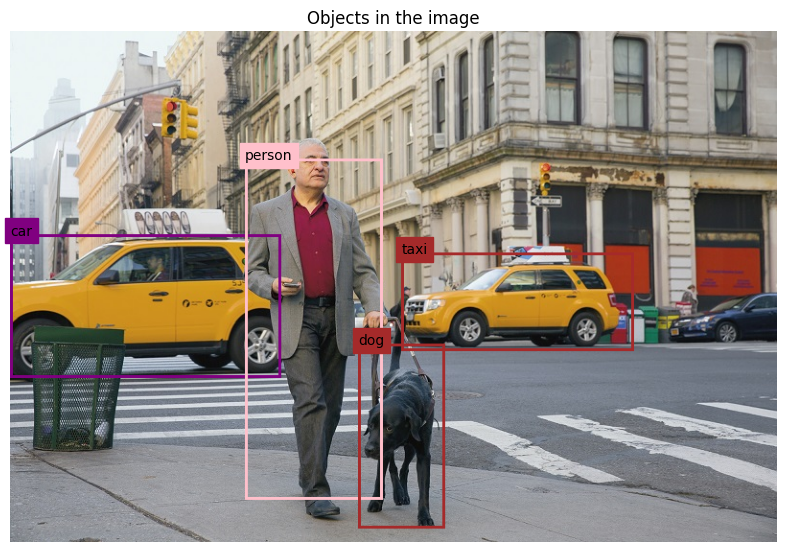

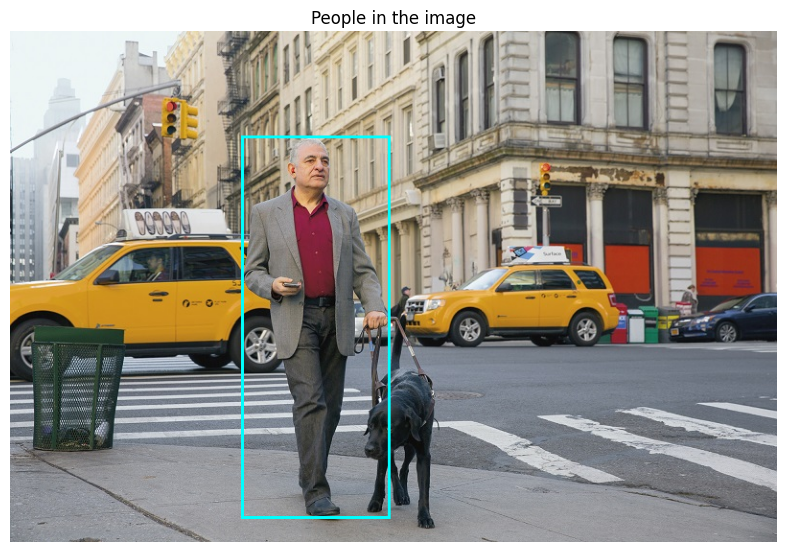

In [163]:
annotate(result, image_file, 'objects', confidence_threshold=0.7)
annotate(result, image_file, 'people', confidence_threshold=0.7)